# <ins> HeartRate Detection Algorithm </ins>

#### PPG (Photoplethysmography):
Photoplethysmography (PPG) is a non-invasive method of measuring blood volume changes in tissues using light. It works by shining light into the skin and measuring the amount of light absorbed or reflected by the blood vessels. PPG can be used to measure heart rate, oxygen saturation, and blood pressure. It is commonly used in pulse oximeters, wearable fitness trackers, and other medical devices. PPG signals are typically acquired at a sampling frequency of 50-1000 Hz and can be analyzed using signal processing techniques such as filtering, peak detection, and frequency analysis. PPG is a simple and inexpensive method of monitoring cardiovascular health and has a wide range of applications in both clinical and non-clinical settings.

### PPG Raw Data: https://physionet.org/content/pulse-transit-time-ppg/1.0.0/
This is high resolution and time synchronised dataset from multiple sensors worn at different body locations including Photoplethysmogram (PPG), Inertial, Pressure and ECG. The recordings are from 22 healthy subjects performing 3 physical activities. This dataset contains 66 waveform records from multi-site and multi-wavelength PPGs, sensors’ attachment pressures, sensors’ temperatures, inertial data from accelerometer and gyroscope, along with annotated ECG data for a total of 19 channels.

Channels:
pleth_1: MAX30101 red wavelength PPG from the distal phalanx (first segment) of the left index finger palmar side (500Hz)</br>
pleth_2: MAX30101 infrared wavelength PPG from the distal phalanx (first segment) of the left index finger palmar side (500Hz)</br>
pleth_3: MAX30101 green wavelength PPG from the distal phalanx (first segment) of the left index finger palmar side (500Hz)</br>
pleth_4: MAX30101 red wavelength PPG from the proximal phalanx (base segment) of the left index finger palmar side (500Hz)</br>
pleth_5: MAX30101 infrared wavelength PPG from the proximal phalanx (base segment) of the left index finger palmar side (500Hz)</br>
pleth_6: MAX30101 green wavelength PPG from the proximal phalanx (base segment) of the left index finger palmar side (500Hz)</br>

### Algorithm:
Step0: Get Raw PPG signal </br>
Step1: Filter the PPG signal with a bandpass filter.</br>
Step2: Check signal quality by calculating Signal to Noise Ratio. </br>
Step3: Differentiate the filtered signal </br>
Step4: Square the differentiated  signal. </br>
Step5: Integrate the squared signal with a sliding window. </br>
Step6: Find the R-peaks in the integrated signal. </br>
Step7: Calculate the heart rate using the time difference between R-peaks. </br>

### Step0: Get Raw PPG signal

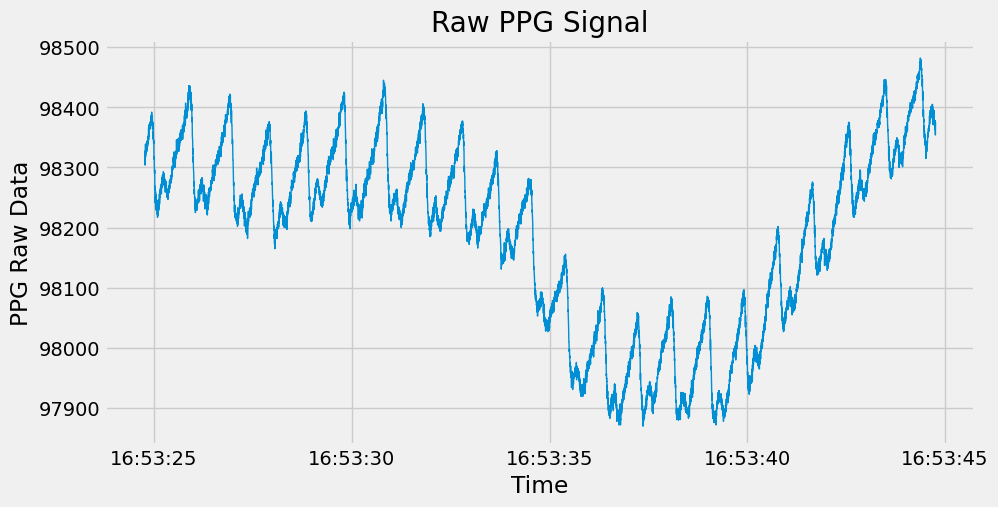

In [1124]:
# Project Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks

# Select channel from the dataset.
channel = 'pleth_5'

df = pd.read_csv('PPG_Dataset/s3_sit.csv')
df.head()

# Data Sampled at 500Hz
# Getting 20 Seconds of raw data
ppg_data = df[['time', channel]].iloc[:10000]

# Convert the time column to a datetime object
ppg_data['time'] = pd.to_datetime(ppg_data['time'], format='%Y-%m-%d %H:%M:%S.%f')

# Set the time column as the dataframe index
ppg_data.set_index('time', inplace=True)

# Plot the PPG data
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
plt.plot(ppg_data.index, ppg_data[channel], linewidth=1)
plt.title("Raw PPG Signal")
plt.xlabel('Time')
plt.ylabel('PPG Raw Data')
plt.show()


 ### <ins> Step1: Filter the PPG signal with a bandpass filter.</br> </ins>
The purpose of filtering is to remove noise and unwanted components from the signal. A bandpass filter is used to pass only the frequency band of interest, which in this case is the heart rate. A typical bandpass filter used for PPG signals has a passband between 0.5 Hz and 8 Hz.

Cut off Frequency fc:</br>
PPG signal contains information mostly in rage of 0.5Hz(30bpm) to 5Hz(300bpm). In our application in most of cases choosing Fc = 1.5Hz gives us the best results since majority of the time heart rate varies between 60bpm(1Hz) to 150bpm(2.5Hz) so choosing 1.5Hz as cutoff frequency gives us best result. 

Sampling Frequency fs:</br>
The sampling frequency should be chosen to be at least twice the cutoff frequency as per Nyquist-Shannon sampling theorem. In our case cutoff frequency of the bandpass filter is chosen to between 0.5 - 5 Hz, the sampling frequency should be chosen to be at least 10 Hz. But we are taking 100Hz for higher accuracy.


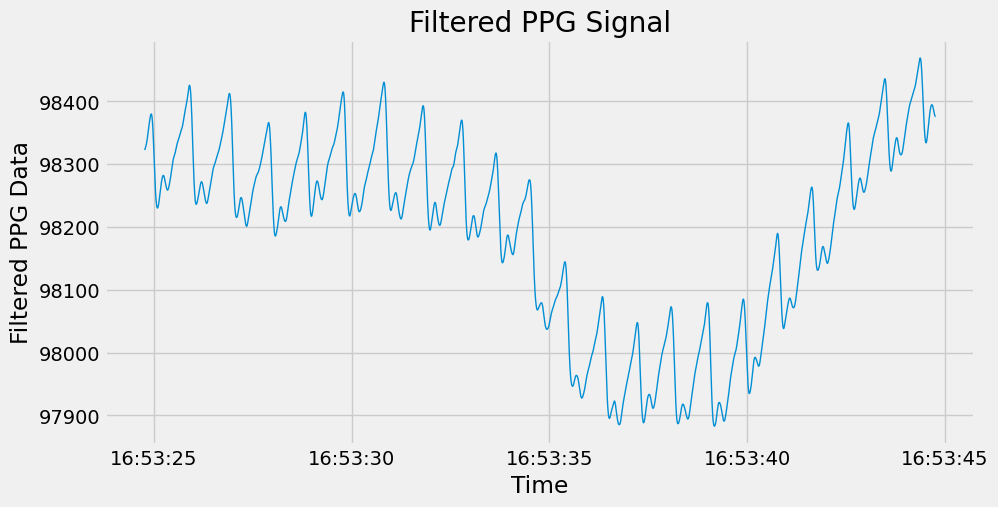

In [1125]:
# Low-pass filter the raw signal to remove noise
fs = 100  # Sampling frequency
fc =  1.5 # Cutoff frequency
b, a = butter(2, 2 * fc / fs, 'low')

ppg_data_raw = ppg_data[channel]
#Applying LP Filter to ppg_data[channel]
ppg_data[channel] = filtfilt(b, a, ppg_data[channel])

ppg_data_filtered = ppg_data[channel]

# Plot the filtered_ppg data
plt.figure(figsize=(10,5))
plt.plot(ppg_data.index, ppg_data[channel], linewidth=1)
plt.title("Filtered PPG Signal")
plt.xlabel('Time')
plt.ylabel('Filtered PPG Data')
plt.show()

### <ins> Step2: Check signal quality by calculating Signal to Noise Ratio. </br> </ins>
If Signal SNR is more than 25dB we consider it as good signal. If it falls below 25dB we give error.  

In [1126]:
# Calculating SNR to find quality of a signal
# Noise signal
THRESHOLD = 25      #dB
noise_data = ppg_data_raw - ppg_data_filtered

signal_power = np.mean(np.abs(ppg_data_filtered)**2)
noise_power = np.mean(np.abs(noise_data)**2)
SNR = 10*np.log10(signal_power/noise_power)
print("SNR: ", SNR)
if SNR < THRESHOLD:
    print("Signal Quality is Bad!")
else: 
    print("Signal Quality is Good!")

SNR:  83.51939690011633
Signal Quality is Good!


### <ins> Step3: Differentiate the filtered signal </ins>
By differentiating the filtered PPG signal, we can enhance the QRS complex in the PPG signal, which can help in detecting the heartbeat accurately. The differentiation operation also introduces noise into the signal, which can be reduced using a smoothing operation like moving average or median filtering. 

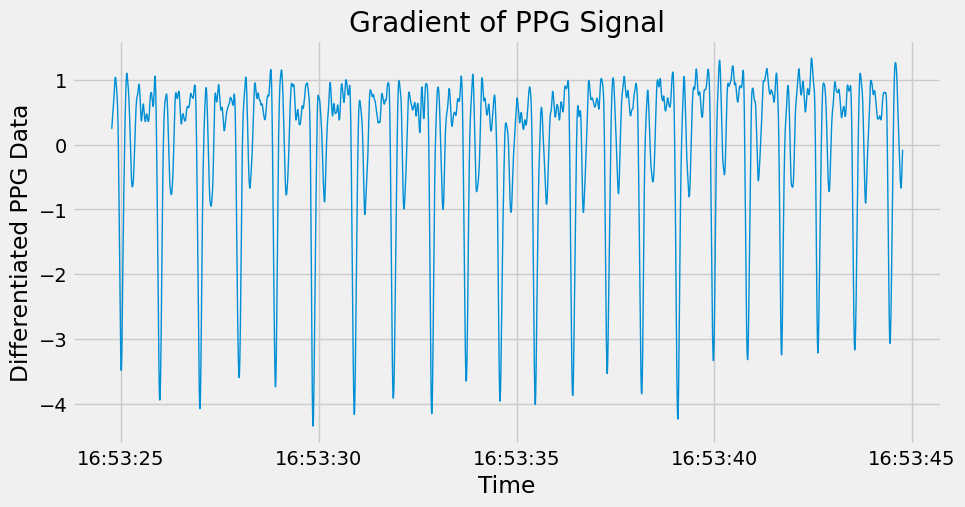

In [1127]:
# Differentiate the filtered signal to emphasize the high-frequency components
ppg_data[channel] = np.gradient(ppg_data[channel])

# Plot the diff_ppg data
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
plt.plot(ppg_data.index, ppg_data[channel], linewidth=1)
plt.title("Gradient of PPG Signal")
plt.xlabel('Time')
plt.ylabel('Differentiated PPG Data')
plt.show()

### <ins> Step4: Square the differentiated  signal. </br> </ins>
Squaring the differentiated signal after it enhances the high-frequency components of the QRS complex and suppresses other low-frequency components in the signal, which improves the detection of the QRS complex in the signal. The squared signal produces prominent peaks where the QRS complex is located, which simplifies the detection process.

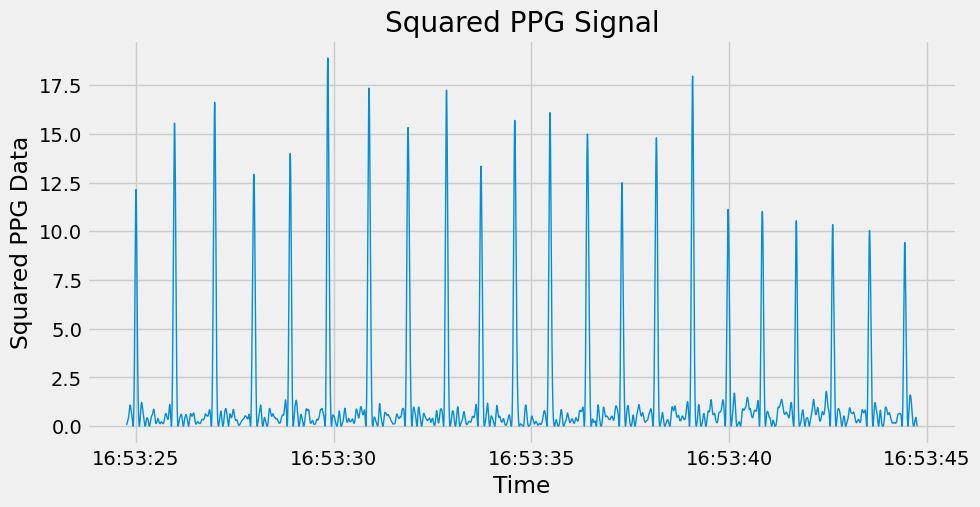

In [1128]:
# Square the differentiated signal to enhance QRS complex
ppg_data[channel] = np.square(ppg_data[channel])
# Plot the square ppg data
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
plt.plot(ppg_data.index, ppg_data[channel], linewidth=1)
plt.title("Squared PPG Signal")
plt.xlabel('Time')
plt.ylabel('Squared PPG Data')
plt.show()

### <ins> Step5:  Integrate the squared signal with a sliding window. </br> </ins>
The purpose of this step is to smooth the signal and amplify the QRS complex even further. Here we have taken 50ms window size means we can take moving average of 50 samples. 

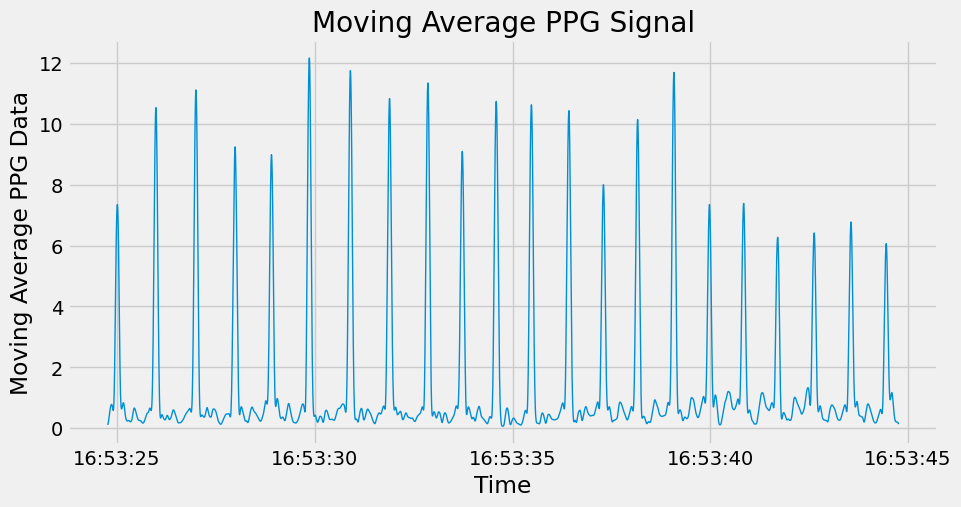

In [1129]:
# Apply a moving average integration to smooth the signal
window_size = int(0.5 * fs)  # 50 window size
window = np.ones(window_size) / float(window_size)
ppg_data[channel] = np.convolve(ppg_data[channel], window, "same")

# Plot the diff_ppg data
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
plt.plot(ppg_data.index, ppg_data[channel], linewidth=1)
plt.title("Moving Average PPG Signal")
plt.xlabel('Time')
plt.ylabel('Moving Average PPG Data')
plt.show()

### <ins> Step6: Find the R-peaks in the integrated signal. </br> </ins>
R peaks correspond to the highest point in the QRS complex, so we find the R peaks in the filtered signal to identify the location of each heartbeat. For this we can find_peaks() method which will return x axis positions of each peaks. Which we can use to calculate Inter Beat Interval(IBI)

In [1130]:
# Find peaks in the integrated signal
ppg_peaks, _ = find_peaks(ppg_data[channel], distance=0.2*fs)
print("ppg_peaks:", ppg_peaks)

ppg_peaks: [  49  122  198  264  337  533  609  686  753  831 1037 1115 1192 1256
 1338 1505 1530 1610 1689 1751 1825 2000 2071 2144 2212 2288 2467 2549
 2623 2688 2762 2829 2924 2972 3068 3143 3208 3287 3433 3488 3563 3640
 3701 3770 3810 3849 3977 4048 4126 4187 4263 4408 4483 4560 4623 4694
 4834 4912 4993 5050 5131 5282 5357 5438 5496 5575 5752 5830 5908 5969
 6045 6128 6195 6267 6340 6402 6478 6622 6699 6775 6838 6918 7086 7158
 7235 7296 7383 7533 7607 7682 7846 7968 8040 8114 8190 8275 8398 8470
 8546 8605 8687 8853 8932 9006 9073 9156 9320 9397 9471 9511 9535 9612
 9771 9842 9912]


### <ins> Step7: Calculate the heart rate using the time difference between R-peaks. </br> </ins>


In [1131]:

# Compute the inter-beat interval (IBI) and heart rate (HR) from the peak locations
ibi = np.diff(ppg_peaks) / fs  # IBI in seconds
hr = 60 / ibi  # HR in bpm

# Output the heart rate measurement
print("Heart rate for file sample_ppg.csv:", np.mean(hr), "bpm")

Heart rate for file sample_ppg.csv: 79.77513271623567 bpm
